# Bayesian Parameter Estimation for Growth Rates

In [3]:
import sys
import numpy as np
import pandas as pd
import glob
import pystan
import altair as alt
sys.path.insert(0, '../../../')
import mwc.viz
import mwc.bayes
import arviz as az
%load_ext stanmagic

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


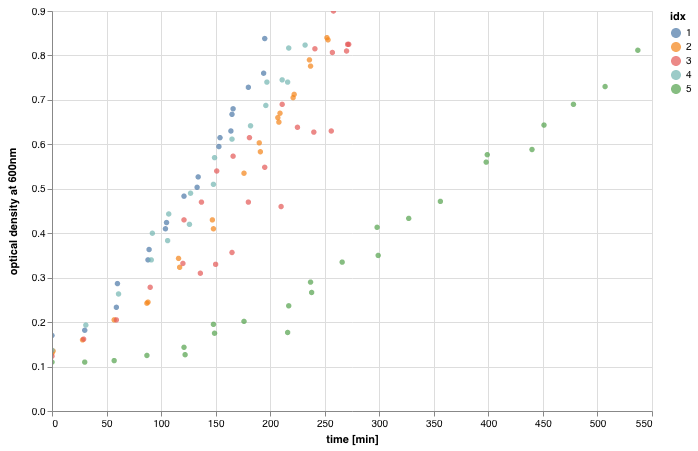

In [4]:
# Define the file pattern for growth experiments of interest. 
growth_files = glob.glob('201809*/*.csv')

# Concatenate all into a single data frame. 
data = pd.concat([pd.read_csv(g) for g in growth_files], sort=False)
data = data[(data['OD_600'] > 0.1) & (data['run_number'] != 3) & (data['date'] != 20180908)].copy()


# Assign identifiers to each unique run. 
run_id = 1
for g, d in data.groupby(['date']):
    data.loc[(data['date']==g),  'idx'] = run_id
    run_id += 1
data = pd.DataFrame(data.groupby(['date', 'elapsed_time_min']).mean()).reset_index()
dfs = []
for g, d in data.groupby(['date']):
    d['elapsed_time_min'] = d['elapsed_time_min'].values - d.iloc[0]['elapsed_time_min']
    dfs.append(d)
data = pd.concat(dfs, sort=False)
data['idx'] = data['idx'].astype(int)




# Plot all of the data together. 
points = alt.Chart(data, width=600, height=400).mark_point(filled=True).encode(
        x=alt.X('elapsed_time_min:Q', axis={'title':'time [min]'}),
        y=alt.Y('OD_600:Q', axis={'title':'optical density at 600nm'}), 
        color='idx:N', )
points.interactive()

It more or less looks like all traces are linear. Using this total pool of data, we can set a hierarchical model. Let there be some Each curve will have it's own growth rate drawn from a distribution for that day, which is drawn from a hyper distribution itself. 

In [7]:
%%stan -v growth_model_code
data {
    int<lower=1> J;
    int<lower=1> N;
    int<lower=1, upper=J> idx[N]; // ID vector 
    real<lower=0> time_min[N]; 
    real<lower=0> absorbance[N];
}

parameters {
    // Hyperparameters
    real<lower=0> lambda_mu; 
    real<lower=0> lambda_sig;
    
    // Low-level parameters
    real<lower=0> lam[J]; // Growth rate in 1/min
    real<lower=0> A0[J]; // Initial absorbance
    real<lower=0> sigma[J]; // Homoscedastic error
    
}

model { 
    vector[N] mu; 
   // Prior definition
   lambda_mu ~ normal(0, 100);
   lambda_sig ~ normal(0, 1); 
    
   lam ~ normal(lambda_mu, lambda_sig);
   A0 ~ normal(0, 1);
   sigma ~ normal(0, 1); 
    
  // Evaluate the likelihood 
  for (i in 1:N) {
      mu[i] = A0[idx[i]] * exp(time_min[i] / lam[idx[i]]); 
      absorbance[i] ~ normal(mu[i], sigma[idx[i]]);
  }
}


Using pystan.stanc compiler..
Failed to parse Stan model 'anon_model_7502f22c16eff8fa9f49d8553cec6e99'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

  error in 'unknown file name' at line 6, column 5
  -------------------------------------------------
     4:     int<lower=1> N;
     5:     int<lower=1, upper=M> media_idx[N]
     6:     int<lower=1, upper=J> run_idx[N]; // ID vector 
            ^
     7:     real<lower=0> time_min[N]; 
  -------------------------------------------------

PARSER EXPECTED: ";"



In [8]:
growth_model = pystan.StanModel(model_code=growth_model_code.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d16d1aafb79b932beb39de7e135532d3 NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmptey7h_q9/stanfit4anon_model_d16d1aafb79b932beb39de7e135532d3_4723503240447984139.cpp:641:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmptey7h_q9/stanfit4anon_model_d16d1aafb79b932beb39de7e135532d3_4723503240447984139.cpp:9215:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [28]:
# Assemble teh data dictionary and sample!
data_dict = dict(J=len(data['idx'].unique()), N=len(data), idx=data['idx'],
                time_min=data['elapsed_time_min'], absorbance=data['OD_600'])
samples = growth_model.sampling(data_dict, iter=8000, chains=4)

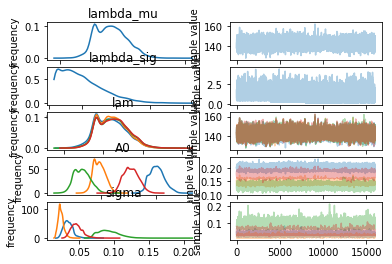

In [29]:
%matplotlib inline
_ = samples.plot()

In [27]:
samples

Inference for Stan model: anon_model_ae7815d3090743092354ccc35324b674.
2 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=5000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda_mu  142.34    0.13   3.42 135.78 140.23 141.97 144.38 149.94    645   1.01
lambda_sig    0.9    0.18   0.63   0.22   0.36   0.76    1.3   2.39     12   1.18
lam[0]      141.9    0.11   3.58 134.92 139.86 141.75 143.87 149.93   1053   1.01
lam[1]     142.28    0.13   3.32 135.88 140.18 141.97 144.21 149.71    654   1.01
lam[2]     142.54    0.14    3.6 135.59 140.34 142.08 144.67 150.37    620   1.01
lam[3]     142.64    0.15    3.6 135.82 140.35 142.16 144.82 150.64    557   1.02
A0[0]         0.2  2.1e-4 6.0e-3   0.19    0.2    0.2    0.2   0.21    814    1.0
A0[1]        0.15  1.3e-4 5.2e-3   0.14   0.14   0.15   0.15   0.16   1597    1.0
A0[2]        0.13  1.6e-4 6.7e-3   0.12   0.13   0.13   0.14   0.15   165

In [235]:
strain_data = pd.concat([pd.read_csv(f) for f in glob.glob('20180917*/*.csv')])
avg_data = pd.DataFrame(strain_data.groupby(['run_number', 'elapsed_time_min']).mean()).reset_index()
dfs = []
for g, d in avg_data.groupby(['run_number']):
    d = d.copy()
    d['elapsed_time_min'] -= d.iloc[0]['elapsed_time_min']
    dfs.append(d)
avg_data = pd.concat(dfs)

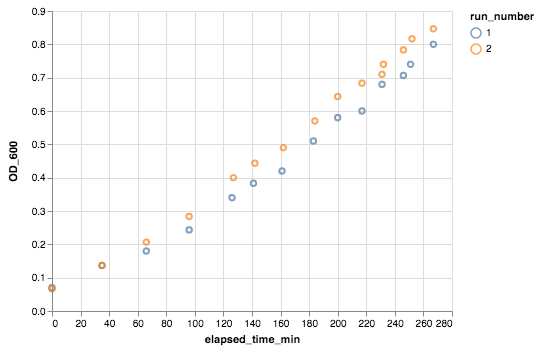

In [236]:
alt.Chart(avg_data).mark_point().encode(
    x='elapsed_time_min:Q',
    y='OD_600:Q',
    color='run_number:N')

In [237]:
# Assemble teh data dictionary and sample!
data_dict = dict(J=len(avg_data['run_number'].unique()), M=1, N=len(avg_data), run_idx=avg_data['run_number'].values.astype(int),
                media_idx=np.ones(len(avg_data)).astype(int), time_min=avg_data['elapsed_time_min'], absorbance=avg_data['OD_600'])
samples = model.sampling(data_dict, iter=8000, chains=4)

In [43]:
samples

Inference for Stan model: anon_model_ae7815d3090743092354ccc35324b674.
4 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda_mu  150.61    0.17   6.38 138.75 146.18 150.51 154.43 164.07   1470    1.0
lambda_sig   0.96    0.06   0.56   0.16   0.54   0.85   1.28   2.33     89   1.04
lam[0]     150.57    0.16   6.36 138.76 146.15 150.47 154.37 164.08   1672    1.0
lam[1]     150.66    0.17   6.38  138.8 146.23 150.59 154.44 164.17   1486    1.0
A0[0]        0.14  2.2e-4 9.1e-3   0.12   0.13   0.14   0.15   0.16   1743    1.0
A0[1]        0.16  2.2e-4   0.01   0.14   0.15   0.16   0.16   0.18   2073    1.0
sigma[0]     0.04  5.0e-4 8.9e-3   0.03   0.03   0.04   0.04   0.06    319   1.01
sigma[1]     0.05  3.3e-4   0.01   0.03   0.04   0.05   0.06   0.08   1191    1.0
lp__        79.86    0.21   2.42  74.34  78.42  80.13   81.6  83.82    1

In [5]:
strain_data = pd.concat([pd.read_csv(f) for f in glob.glob('20180920*/*.csv')])
# strain_data = strain_data[strain_data['OD_600'] > 0.1]
avg_data = pd.DataFrame(strain_data.groupby(['run_number', 'time_elapsed_min', 'growth_medium']).mean()).reset_index()
dfs = []
for g, d in avg_data.groupby(['run_number']):
    d = d.copy() 
    d.sort_values('time_elapsed_min', inplace=True)
#     d['time_elapsed_min'] -= d.iloc[0]['time_elapsed_min']
    d['A_A0'] = d['OD_600'].values / d.iloc[0]['OD_600']
    dfs.append(d)
avg_data = pd.concat(dfs)

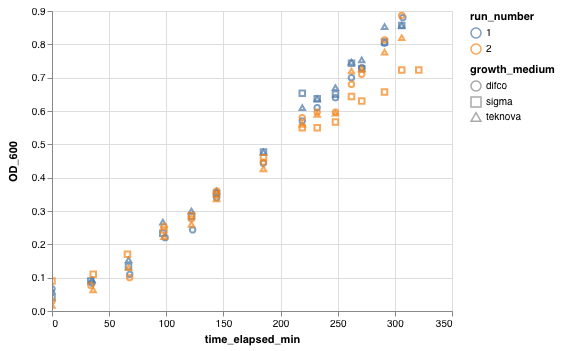

In [6]:
alt.Chart(avg_data).mark_point().encode(
    x='time_elapsed_min:Q',
    y=alt.X('OD_600:Q'),
    color='run_number:N',
    shape='growth_medium:O').interactive()

In [12]:
%%stan -v growth_model_code
data {
    int<lower=1> M;
    int<lower=1> J;
    int<lower=1> N;
    int<lower=1, upper=M> media_idx[N];
    int<lower=1, upper=J> run_idx[N]; // ID vector 
    real<lower=0> time_min[N]; 
    real<lower=0> absorbance[N];
}

parameters {
    // Hyperparameters
    real<lower=0> lambda_mu[M]; 
    real<lower=0> lambda_sig[M];
    // Low-level parameters
    matrix<lower=0>[M, J] lam; // Growth rate in 1/min
    matrix<lower=0>[M, J] A0; // Initial absorbance
    matrix<lower=0>[M, J] sigma; // Homoscedastic error
    
}

model { 
    vector[N] mu; 
    lambda_mu ~ inv_gamma(1, 2);
    lambda_sig ~ normal(0, 1); 

   // Prior definition 
    for (j in 1:M){
        for (i in 1:J){
           lam[j, i] ~ normal(lambda_mu[j], lambda_sig[j]);
           A0[j, i] ~ normal(0, 1);
           sigma[j, i] ~ normal(0, .1); 
    } 
    }
  // Evaluate the likelihood 
  for (i in 1:N) {
      mu[i] = A0[media_idx[i], run_idx[i]] * exp(-exp(-time_min[i] / lam[media_idx[i],run_idx[i]])); 
      absorbance[i] ~ normal(mu[i], sigma[media_idx[i],run_idx[i]]);
  }
}

generated quantities {
    matrix<lower=0>[M, J] t_double;
    real y_rep[N];
    for (j in 1:M) {
        for (i in 1:J) {
        t_double[j, i] = -log(log(2)) * lam[j, i];
        }
    }
    for (i in 1:N) {
        y_rep[i] = normal_rng(A0[media_idx[i], run_idx[i]] * exp(-exp(-time_min[i] / lam[media_idx[i], run_idx[i]])),
                             sigma[media_idx[i], run_idx[i]]);
    }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in growth_model_code object.
Type growth_model_code in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^^^^^^
Access model compile output properties
growth_model_code.model_file -> Name of stan_file [None]
growth_model_code.model_name -> Name of stan model [None]
growth_model_code.model_code -> Model code [data {     int<lower ....]


In [13]:
model = pystan.StanModel(model_code=growth_model_code.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_745903d20ede2d302a751a343180aca0 NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpmr259kpd/stanfit4anon_model_745903d20ede2d302a751a343180aca0_8785424130321482461.cpp:642:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpmr259kpd/stanfit4anon_model_745903d20ede2d302a751a343180aca0_8785424130321482461.cpp:9397:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [14]:
# Assign a media key. 
media_key = {m:i + 1  for i, m in enumerate(avg_data['growth_medium'].unique())}
for m, idx in media_key.items():
    avg_data.loc[avg_data['growth_medium']==m, 'medium_idx'] = idx
avg_data['medium_idx'] = avg_data['medium_idx'].astype(int)

In [15]:
# Assemble the data dictionary and sample!
data_dict = dict(M=len(avg_data['growth_medium'].unique()),
                 J=len(avg_data['run_number'].unique()), 
                 N=len(avg_data), run_idx=avg_data['run_number'].values.astype(int),
                 media_idx=avg_data['medium_idx'].values,
                time_min=avg_data['time_elapsed_min'], absorbance=avg_data['OD_600'])
samples = model.sampling(data_dict, iter=8000, chains=3, thin=10)

In [16]:
samp_df = samples.to_dataframe()

In [ ]:
samps = [np.median(samp_df['y_rep[{}]'.format(i+1)]) for i in range(len(avg_data))]

In [ ]:
_yrep = pd.DataFrame(np.array([samps, avg_data['time_elapsed_min']]).T, columns=['y_rep', 'time'])
avg_data['log_abs'] = np.log(avg_data['OD_600'])
# Plot the ppc data over the 
points = alt.Chart(avg_data).mark_point(filled=True, color='slategray', opacity=0.5).encode( 
            x=alt.X('time_elapsed_min:Q'),
            y=alt.Y('OD_600:Q'))
reps = alt.Chart(_yrep).mark_point(filled=True, color='firebrick').encode(
            x=alt.X('time:Q'),
            y=alt.Y('y_rep:Q'))

points + reps

In [124]:
samples


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_fc7a49b4136685f164f35233c7ee02ca.
3 chains, each with iter=8000; warmup=4000; thin=10; 
post-warmup draws per chain=400, total post-warmup draws=1200.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda_mu[1]  167.18    0.31   9.23 153.28 161.81 165.27 171.55 187.97    876    1.0
lambda_mu[2]  219.84    0.77  17.66 193.64 206.86 217.19 228.86 259.55    521   1.01
lambda_mu[3]  178.47     0.3   9.82 161.47 172.39 177.63 183.69 200.99   1090    1.0
lambda_sig[1]    0.9    0.08   0.56   0.14   0.43    0.8   1.23   2.23     46   1.08
lambda_sig[2]    1.0    0.04   0.56   0.22   0.55   0.91   1.45   2.29    167   1.02
lambda_sig[3]   0.89    0.04   0.53   0.17   0.49   0.78   1.17   2.26    190   1.01
lam[1,1]      167.16    0.31   9.24 153.33 161.65 165.32 171.45 187.52    874    1.0
lam[2,1]      219.82    0.81  17.71 193.84  206.8 217.38  229.2 259.84    476   1.01
lam[3,

In [115]:
%matplotlib inline
_ = ar.plot_forest(samples)

NameError: name 'ar' is not defined

In [167]:
ar.ppcplot.

SyntaxError: invalid syntax (<ipython-input-167-9d100cdbe656>, line 1)